# Your First Image Classifier: Using k-NN, MLP and CNN to Classify Images
# Test

The purpose of this dataset is to correctly classify an image as containing a dog, cat, or panda.
Containing only 3,000 images, the Animals dataset is meant to be another **introductory** dataset
that we can quickly train a KNN, MLP or CNN model and obtain initial results that has potential to be used as a baseline. 

Let's take the following steps:

1. Download the encoder and model artifacts
2. Evaluate the model using the test dataset
3. Create an interactive table

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1a-nyAPNPiVh-Xb2Pu2t2p-BhSvHJS0pO"></center>

## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [ ]:
!pip install wandb -qU

In [ ]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: thaisaraujom. Use `wandb login --relogin` to force relogin


True

### Import Packages

In [21]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

In [22]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Step 02 Test evaluation

In [23]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "first_image_classifier",
  "test_feature_artifact": "test_x:latest",
  "test_target_artifact": "test_y:latest",
  "encoder": "target_encoder:latest",
  "inference_model": "model:latest",
  "deploy": "inference_result"
}

In [24]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="thaisaraujom",project=args["project_name"], job_type="Test")

logger.info("Downloading the test data")
test_x_artifact = run.use_artifact(args["test_feature_artifact"])
test_x_path = test_x_artifact.file()
test_y_artifact = run.use_artifact(args["test_target_artifact"])
test_y_path = test_y_artifact.file()

# unpacking the artifacts
test_x = joblib.load(test_x_path)
test_y = joblib.load(test_y_path)

16-10-2022 05:03:49 Downloading the test data


In [25]:
logger.info("Downloading the encoder and inference model")
encoder_artifact = run.use_artifact(args["encoder"])
encoder_path = encoder_artifact.file()
model_artifact = run.use_artifact(args["inference_model"])
model_path = model_artifact.file()

# unpacking the artifacts
encoder = joblib.load(encoder_path)
model = joblib.load(model_path)

16-10-2022 05:03:52 Downloading the encoder and inference model


In [26]:
# encode the labels as integers
test_y = encoder.transform(test_y)

# train 
logger.info("[INFO] evaluating...")
predict = model.predict(test_x)

16-10-2022 05:03:56 [INFO] evaluating...


In [27]:
print(classification_report(test_y, predict,target_names=encoder.classes_))

              precision    recall  f1-score   support

        cats       0.52      0.58      0.55       262
        dogs       0.46      0.49      0.47       249
       panda       0.81      0.67      0.73       239

    accuracy                           0.58       750
   macro avg       0.60      0.58      0.58       750
weighted avg       0.59      0.58      0.58       750



In [28]:
# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(test_y, predict, beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y, predict, zero_division=1,average='weighted')
recall = recall_score(test_y, predict, zero_division=1,average='weighted')
acc = accuracy_score(test_y, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

16-10-2022 05:04:01 Test Evaluation metrics
16-10-2022 05:04:01 Test Accuracy: 0.576
16-10-2022 05:04:01 Test Precision: 0.5927309146567898
16-10-2022 05:04:01 Test Recall: 0.576
16-10-2022 05:04:01 Test F1: 0.5816983246283268


In [29]:
encoder.classes_

array(['cats', 'dogs', 'panda'], dtype='<U5')

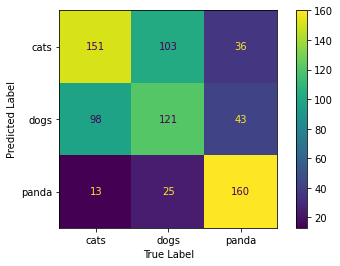

In [30]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,test_y),
                       display_labels=encoder.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [31]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

16-10-2022 05:04:08 Uploading figures


In [ ]:
# create a folder named 'test'
dirname = 'test'
os.mkdir(dirname)

# re-generate test images and put all of them in test/ folder
for i in range(test_x.shape[0]):
  img = test_x[i].reshape(32,32,3)
  cv2.imwrite(os.path.join(dirname,''.join([str(i),'.jpg'])),img)

In [33]:
# sort image Paths by name
# 0.jpg, 1.jpg, 2.jpg, ....
imagePaths = list(paths.list_images("test"))
imagePaths = sorted(imagePaths, key=lambda x: int(re.search(r"(\d+)\.[a-z]+$", x).group(1)))

In [34]:
# create a table with columns we want to track/compare
preview_dt = wandb.Table(columns=["test id","image", "target","predict"])

# create a new artifact to store the EDA data
inference_result = wandb.Artifact(args["deploy"], type="INFERENCE")

In [35]:
# append all images to the artifact
for i,img in enumerate(imagePaths):
  image = cv2.imread(img)
  preview_dt.add_data(i, 
                      wandb.Image(img), 
                      encoder.inverse_transform([test_y[i]])[0], 
                      encoder.inverse_transform([predict[i]])[0])

In [36]:
# save artifact to W&B
inference_result.add(preview_dt, "Inference_Table")
run.log_artifact(inference_result)

In [37]:
run.finish()

Acc,0.576
F1,0.5817
Precision,0.59273
Recall,0.576
